The problem

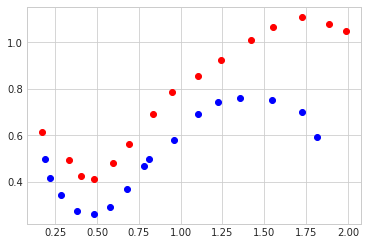

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
scale = 1/300
goal = scale * np.array([(51,184), (99,148), (121,127), (145,124), (179,144), (207,169), (251,207), (284,236), (331,257), (373,277), (426,303), (466,320), (517,333), (566,324), (597,315)])
template = scale * np.array([(56,149), (66,125), (85,103), (114,82), (144,78), (173,87), (203,111), (234,141), (243,149), (288,174), (331,207), (367,223), (406,228), (464,225), (517,210), (545,178)])
edges = np.vstack([
    np.arange(len(template)),
    np.roll(np.arange(len(template)), -1)
]).T

plt.plot(goal[:, 0], goal[:, 1], 'o', color='red');
plt.plot(template[:, 0], template[:, 1], 'o', color='blue');



A template mesh $\mathcal{S} = (\mathcal{V, E})$ with vertices $\mathcal{V}$ and edges $\mathcal{E}$ is to be deformed to match a target surface $\mathcal{T}$. The target surface needs to be defined in such a way that we can compute a distance from a point to it.

$\mathbf{X} = [\mathbf{X}_1 · · · \mathbf{X}_n]^T$

### The objective function

Minimize

$$
\overline{\boldsymbol{E}}(\boldsymbol{X}) = \overline{\boldsymbol{E}}_d(\boldsymbol{X}) + α\boldsymbol{E}_s(\boldsymbol{X}) + β\boldsymbol{E}_l(\boldsymbol{X})
$$

Distance term

$$
\boldsymbol{E}_d(\boldsymbol{X}) = \sum\limits_{\boldsymbol{v}_i \in \mathcal{V}} w_i \operatorname{dist}^2(\mathcal{T}, \boldsymbol{X}_i\boldsymbol{v}_i)
$$

Stiffness term

$$
\boldsymbol{E}_s(\boldsymbol{X}) = \sum\limits_{(i, j) \in \mathcal{E}} \Vert (\boldsymbol{X}_i - \boldsymbol{X}_j)\boldsymbol{G} \Vert _F^2
$$


Landmark term

$$
\boldsymbol{E}_l(\boldsymbol{X}) = \sum\limits_{(\boldsymbol{v}_i, \mathbf{l}) \in \mathcal{L}} \Vert (\boldsymbol{X}_i\mathbf{v}_i - \boldsymbol{l})\boldsymbol{G} \Vert ^2
$$


Distance term with fixed correspondences $(\boldsymbol{v}_i, \boldsymbol{u}_i)$
$$
\overline{\boldsymbol{E}}(\boldsymbol{X}) = \sum\limits_{\boldsymbol{v}_i \in \mathcal{V}} w_i \Vert \boldsymbol{X}_i\boldsymbol{v}_i - \mathbf{u}_i \Vert ^2
$$

The fixed correspondences can be re-written on the following form

$$
\overline{\boldsymbol{E}}(\boldsymbol{X}) = \Vert \boldsymbol{AX} - \boldsymbol{B} \Vert ^2_F
$$

$\boldsymbol{X}$ takes minimum value where the derivative is zero

$$
\boldsymbol{X} = (\boldsymbol{A}^T \boldsymbol{A})^{−1}\boldsymbol{A}^T \boldsymbol{B}
$$

### Algorithm
* Initialise $\boldsymbol{X}_0$
* For each stiffness $\alpha$
  * Until $\Vert \boldsymbol{X}^j − \boldsymbol{X}^{j−1} \Vert < \epsilon$
    * Find preliminary correspondences for $\mathcal{V}(X^{j−1})$
    * Determine $\boldsymbol{X}^j$ as the optimal deformation for the preliminary correspondences and $\alpha_i$

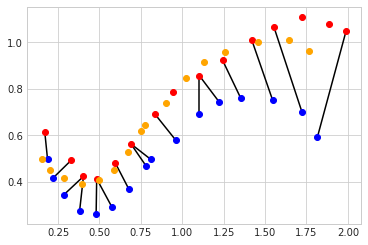

In [92]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve


def closest_point(point, points):
    """Naive closest point"""
    dist2 = np.sum((np.asarray(points) - point)**2, axis=1)
    index = np.argmin(dist2)
    return points[index]


class Eq:
    def __init__(self):
        self.row_indices = []
        self.column_indices []
        self.values = []
        self.rhs = []
    
    def add_equation(self, w, rhs, pairs):
        row = len(self.rhs)
        for column, value in pairs:
            self.row_indices.append(row)
            self.column_indices.append(column)
            self.values = w * value
            self.triplets.append((row, column, w * value))
        self.rhs.append(w * rhs)
    
    def matrices(self):
        row_ind = [r for r, _, _ in self.triplets]
        col_ind = [c for _, c, _ in self.triplets]
        data = [d for _, _, d in self.triplets]
        return csr_matrix((data, (row_ind, col_ind))), np.array(self.rhs)
 

def parameter_index(i, row, column):
    return 6 * i + 3 * row + column


def step(template, goal, pts, stiffness):
    eq = Eq()
    # distance costs
    dw = 0.1  # distance weight
    for i, v in enumerate(template):
        g = closest_point(v, goal)
        plt.plot([v[0], g[0]], [v[1], g[1]], color='black')
        for dim in range(2):
            eq.add_equation(dw / 2, g[dim], [
                (parameter_index(i, dim, 0), v[0]),
                (parameter_index(i, dim, 1), v[1]),
                (parameter_index(i, dim, 2), 1)])

    # stiffness costs
    for e0, e1 in edges:
        for row in range(2):
            for col in range(3):
                eq.add_equation(stiffness, 1, [
                    (parameter_index(e0, row, col), +1),
                    (parameter_index(e1, row, col), -1)
                ])

    A, b = eq.matrices()
    X = spsolve(A.T * A, A.T * b)
    for i, v in enumerate(template):
        for d in range(2):
            pts[i, d] = \
                X[parameter_index(i, d, 0)] * v[0] + \
                X[parameter_index(i, d, 1)] * v[1] + \
                X[parameter_index(i, d, 2)]
    return pts


pts = np.copy(template)
#for i in range(5):
#    plt.plot(pts[:, 0], pts[:, 1], 'o', color='orange')
#    t = 1 - (i+1) / 10
#    stiffness = t
#    print(stiffness)
pts = step(template, goal, pts, stiffness=1)
    
plt.plot(goal[:, 0], goal[:, 1], 'o', color='red');
plt.plot(template[:, 0], template[:, 1], 'o', color='blue')
plt.plot(pts[:, 0], pts[:, 1], 'o', color='orange')
